In [132]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from enum import Enum
import matplotlib as mpl
import geopandas as gpd
from tqdm import tqdm_notebook as tqdm
from operator import itemgetter
from sklearn.preprocessing import StandardScaler

In [137]:

raw_NDVI_input = np.load("raw_NDVI_input.npy")
raw_NDWI_input = np.load("raw_NDWI_input.npy")
inpatches = np.load("FullInput.npy")
outpatches = np.load("FullOutput.npy")

In [3]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [4]:
print(X_list[0].shape,
      y_list[0].shape)

(3, 337, 333, 3) (337, 333, 1)


In [5]:
raw_NDVI_input[0].shape

(69, 337, 333, 1)

In [6]:
md_input = []
for patch in inpatches:
    temp = patch
    tempin = itemgetter(0,3,8,9,11,17)(temp)
    done = np.delete(tempin, [3,4,5], 3)
    md_input.append(done)

eval_patch = np.delete(inpatches[0][25], [3,4,5], 2)
print(eval_patch.shape)
print(outpatches.shape)

(337, 333, 3)
(9, 337, 333, 1)


In [48]:
#CALCULATING EVI
def evi_small(image):
    evi_small_list = []
    for row in image:
        for px in row: 
            band_a = px[3]
            band_b = px[2]
            band_c = px[0]
            EVI = 2.5 * (band_a - band_b) / ((band_a + 6.0 * band_b - 7.5 * band_c) + 1.0)
            evi_small_list.append(EVI) 
    evi_small_array = np.array(evi_small_list).reshape(337, 333, 1)
    evi_small_array = evi_small_array.astype("float32")
    return evi_small_array


def evi_large(image_list):
    patches = [] #9 in total when finished
    for patch in image_list:
        images = [] #6 in total when finished
        for image in patch:
            small_array = evi_small(image)
            images.append(small_array)
        patches.append(images)
    return patches
        
            

In [8]:
def patch_selector(inputlist):
    new_list = []
    for patch in inputlist:
        temp = patch
        tempin = np.array(itemgetter(0,3,8,9,11,17)(temp))
        #use if RGB# done = np.delete(tempin, [3,4,5], 3)
        new_list.append(tempin)
    return new_list


In [150]:
NDVI_input = patch_selector(raw_NDVI_input)
NDWI_input = patch_selector(raw_NDWI_input)
temp_raw_evi = patch_selector(inpatches)

In [49]:
EVI_input = evi_large(temp_raw_evi)

In [50]:
EVI_input[0][0].shape

(337, 333, 1)

In [14]:
test_set[0].shape

(1, 337, 333, 6)

In [15]:
NDVI_input[0].shape


(6, 337, 333, 1)

In [16]:
NDWI_input[0].shape

(6, 337, 333, 1)

In [17]:
temp_raw_evi[0].shape

(6, 337, 333, 6)

In [18]:
learning_rates= ["adaptive", "constant", "invscaling"]
activations = ["identity", "logistic", "tanh", "relu"]
solvers = ["lbfgs", "sgd", "adam"]

In [17]:
def algorithm_accuracy():
    score_list = []
    progress = 0
    for learning_rate_ in learning_rates:
        for activation_ in activations:
            for solver_ in solvers:
                for ptc in range(len(outpatches)):
                    for img in md_input[ptc]:
                        img_idx = 0
                        if img_idx == 0:
                            md_mlp = MLPClassifier(warm_start=False, learning_rate=learning_rate_, activation=activation_, solver=solver_)
                            temp_img = img.reshape(112221, 3)
                            temp_output = outpatches[ptc].reshape(112221, 1)
                            try :
                                md_mlp.fit(temp_img, temp_output)
                                score = md_mlp.score(eval_patch.reshape(112221, 3), outpatches[0].reshape(112221, 1))
                            except: 
                                print(f"The algorithm cannot calculate a result for these parameters: {learning_rate_}, {activation_}, {solver_}")

                        else: 
                            md_mlp = MLPClassifier(warm_start=True, learning_rate=learning_rate_, activation=activation_, solver=solver_)
                            temp_img = img.reshape(112221, 3)
                            temp_output = outpatches[ptc].reshape(112221, 1)
                            try :
                                md_mlp.fit(temp_img, temp_output)
                                score = md_mlp.score(eval_patch.reshape(112221, 3), outpatches[0].reshape(112221, 1))
                            except: 
                                print(f"The algorithm cannot calculate a result for these parameters: {learning_rate_}, {activation_}, {solver_}")

                        score_list.append(score)
                        del temp_img, temp_output
                        img_idx += 1
                progress += 2.77
                print(f"Progress: {progress}%")

In [21]:
def input_scaler(X_data, i, j, y):
    scaler = StandardScaler()
    scaler.fit(X_data[0][0].reshape(112221, y))
    temp_res = scaler.transform(X_data[i][j].reshape(112221, y))
    return temp_res.reshape(337,333,y)


In [151]:
rgb_input_r = md_input
ndvi_input_r = NDVI_input
ndwi_input_r = NDWI_input
evi_input_r = EVI_input

def large_scaler(X_data, y=1):
    scaled_list = []
    for i in range(9):
        scaled_arry = []
        for j in range(6):
            scaled_arry.append(input_scaler(X_data, i, j, y))
        scaled_list.append(scaled_arry)
    return scaled_list
        

In [152]:
rgb_input = large_scaler(rgb_input_r, 3)
ndvi_input = large_scaler(ndvi_input_r)
ndwi_input = large_scaler(ndwi_input_r)
evi_input = large_scaler(evi_input_r)

In [94]:
def test_set_gen():
    test_rgb_r = []
    test_ndvi_r = []
    test_ndwi_r = []
    raw_test_evi_r = []
    
    
    def input_scaler(X_data, i, j, y):
        scaler = StandardScaler()
        scaler.fit(X_data[0].reshape(112221, y))
        temp_res = scaler.transform(X_data[i].reshape(112221, y))
        return temp_res.reshape(337,333,y) 
    
    def large_scaler_test(X_data, y=1):
        scaled_list = []
        for i in range(9):
            scaled_arry = []
            for j in range(1):
                scaled_arry.append(input_scaler(X_data, i, j, y))
            scaled_list.append(scaled_arry)
        return scaled_list


    for patch in raw_NDVI_input:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        test_ndvi_r.append(tempin)
    for patch in raw_NDWI_input:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        test_ndwi_r.append(tempin)
    for patch in inpatches:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        raw_test_evi_r.append(tempin)
    test_evi_r = evi_large(np.array(raw_test_evi_r).reshape(9, 1, 337, 333, 6))   
    for i in range(9):
        test_rgb_r.append(np.delete(inpatches[i][25], [3,4,5], 2))
    
    test_rgb = large_scaler_test(test_rgb_r, y=3)
    test_ndvi = large_scaler_test(test_ndvi_r)
    test_ndwi = large_scaler_test(test_ndwi_r)
    test_evi = large_scaler_test(np.array(test_evi_r))
    test_set = []
    for i in range(9):
        patch_with_images = np.concatenate((np.array(test_rgb[i]).reshape(1, 337, 333, 3),
                  np.array(test_ndvi[i]).reshape(1, 337, 333, 1),
                  np.array(test_ndwi[i]).reshape(1, 337, 333, 1), np.array(test_evi[i]).reshape(1, 337, 333, 1)), axis=3)
        test_set.append(patch_with_images)
    return test_set
        

In [95]:
test_set = test_set_gen()

In [79]:
evi_test.shape

NameError: name 'evi_test' is not defined

In [99]:
test_set[0].shape

(1, 337, 333, 6)

In [97]:
evi_input[0][0][0][0]

array([-0.71885408])

In [52]:
input_scaler(ndvi_input)

[0.30558079]


In [35]:
ndvi_input[0].shape

(6, 337, 333, 1)

In [ ]:
scaler = StandardScaler()

In [58]:
np.amin(outpatches[0])

0

In [122]:
test_set[0].shape

(1, 337, 333, 6)

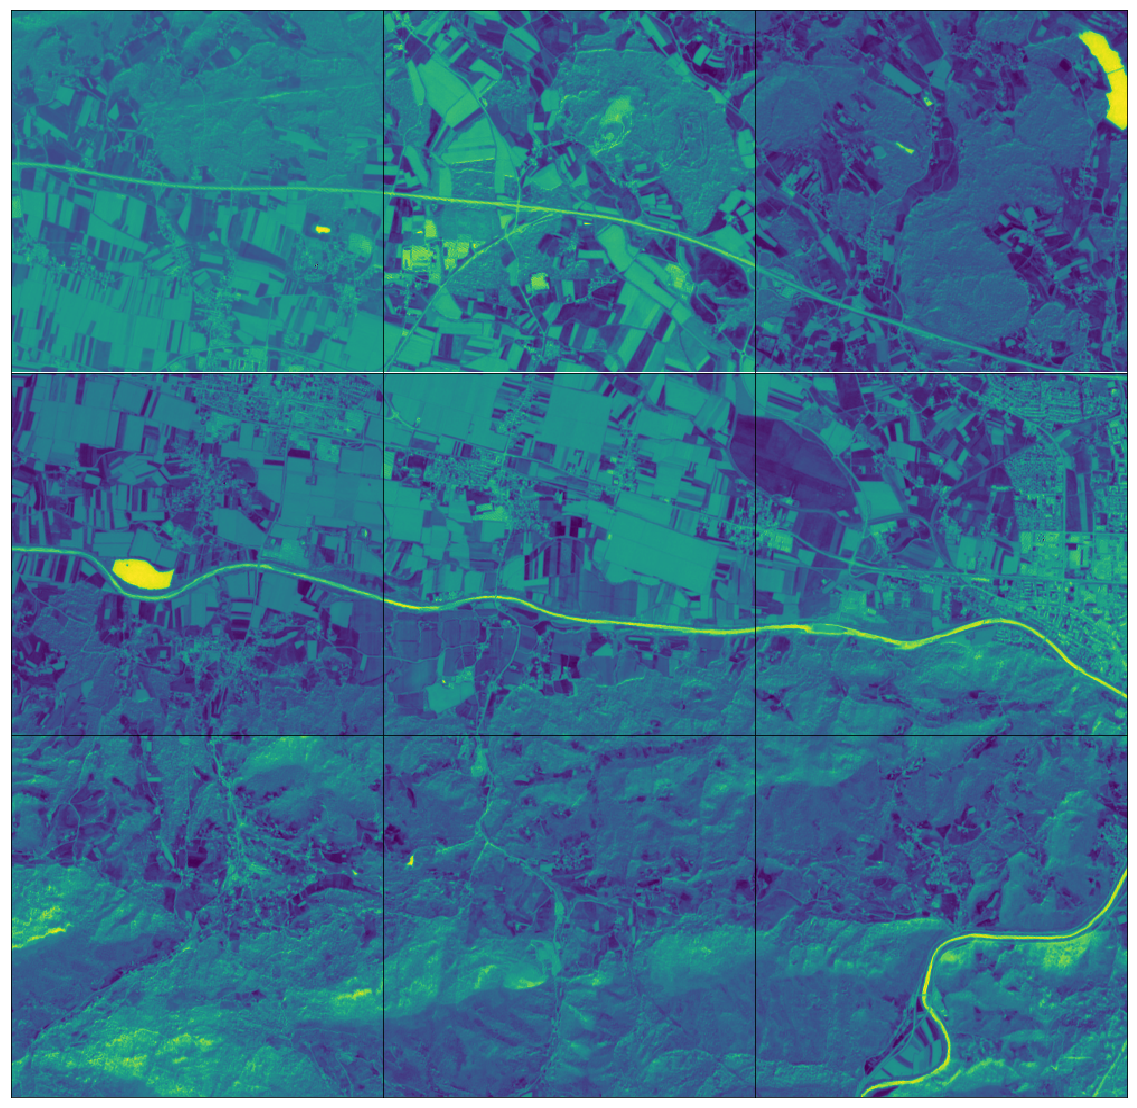

In [154]:
fig = plt.figure(figsize=(20, 20 * 1))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = ndwi_input[i][:][:][3]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(eopatch.squeeze())
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)


In [32]:
pilot_data = np.concatenate((rgb_input[0][0],
              ndvi_input[0][0],
              ndwi_input[0][0],
              evi_input[0][0]), axis=2)

In [19]:
pilot_data.shape

(337, 333, 6)

In [57]:
def combination_evaluation(pass0):
    score_list = []
    result_list = []
    for learning_rate_ in learning_rates:
        for activation_ in activations:
            for solver_ in solvers:
                mlp = MLPClassifier(warm_start=False, learning_rate=learning_rate_, activation=activation_, solver=solver_)
                mlp.fit(pilot_data.reshape(112221, 6), outpatches[0].reshape(112221))
                score = mlp.score(dataset_large[1][0].reshape(112221, 6), outpatches[1].reshape(112221))
                result = mlp.predict(dataset_large[1][0].reshape(112221, 6))
                score_list.append(score)
                result_list.append(result)
    
    fig, axes = plt.subplots(figsize=(20, 20 * 1), nrows=6, ncols=6)
    for i, ax in enumerate(axes.flat):
        eopatch = result_list[i].reshape(337,333,1)
        im = ax.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")
        del eopatch

    fig.subplots_adjust(wspace=0, hspace=0)
    print(score_list)
        
    import smtplib, ssl

    

In [33]:
mlp = MLPClassifier(warm_start=False, learning_rate="adaptive", activation="relu", solver="adam")
mlp.fit(pilot_data.reshape(112221, 6), outpatches[0].reshape(112221))
score0 = mlp.score(dataset_large[1][0].reshape(112221, 6), outpatches[1].reshape(112221))
score1= mlp.score(dataset_large[3][0].reshape(112221, 6), outpatches[3].reshape(112221))
score2= mlp.score(dataset_large[4][0].reshape(112221, 6), outpatches[4].reshape(112221))
control= mlp.score(dataset_large[1][5].reshape(112221, 6), outpatches[1].reshape(112221))

print(score0, score1, score2, control)

C:\Users\Irena\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8061503640138655 0.8092959428271 0.8298714144411474 0.6922144696625409


In [ ]:
mlp.fit(pilot_data.reshape(112221, 6), outpatches[0].reshape(112221, 1))

In [64]:
mlp.score(np.concatenate((rgb_input[1][0],
              ndvi_input[1][0],
              ndwi_input[1][0],
              evi_input[1][0]), axis=2).reshape(112221, 6), outpatches[1].reshape(112221,1))
mlp.classes_

array([0, 2, 3])

In [65]:
fig = plt.figure(figsize=(20, 20 * 1))

eopatch = pilot_prediction.reshape(337,333,1)
plt.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])

del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

NameError: name 'pilot_prediction' is not defined

<Figure size 1440x1440 with 0 Axes>

In [128]:
## MACRO CLASSIFICATION for RGB, NDVI, NDWI, EVI
dataset_large = []
for i in range(9):
    patch_with_images = np.concatenate((rgb_input[i],
              ndvi_input[i],
              ndwi_input[i],
              evi_input[i]), axis=3)
    dataset_large.append(patch_with_images)


    

In [26]:
dataset_large[0].shape

(6, 337, 333, 6)

In [177]:
xlmlp = MLPClassifier(warm_start=False, learning_rate="adaptive", activation="relu", solver="adam")
for i in range(9):
    for image in dataset_large[i]:
        xlmlp.fit(image.reshape(112221, 6), outpatches[i].reshape(112221))

for i in range(9):
    print(xlmlp.score(test_set[i].reshape(112221, 6), outpatches[i].reshape(112221)))

C:\Users\Irena\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Irena\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Irena\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Irena\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

0.6101086249454202
0.4962618404754903
0.5198937810213775
0.6486664706249275
0.6111690325340177
0.6104561534828598
0.7121839940831038
0.780335231373807
0.7612033398383546


In [113]:
lmlp = MLPClassifier(warm_start=True, learning_rate="adaptive", activation="relu", solver="adam")
for i in range(9):
    for image in dataset_large[i]:
        lmlp.fit(image.reshape(112221, 6), outpatches[i].reshape(112221))
    print(lmlp.score(test_set[i].reshape(112221, 6), outpatches[i].reshape(112221)))

0.5317275732705999
0.5353989003840636
0.294062608602668
0.686003510929327
0.738667450833623
0.5515188779283735
0.19884870033237986
0.13862824248580924
0.19068623519662095


In [106]:
##ALTERNATE CLASSIFIER
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(objective="multiclass", num_class = 3, metric="multi_logloss")
for i in range(1):
    for image in dataset_large[i]:
        lgbm.fit(image.reshape(112221, 6), outpatches[i].reshape(112221))

for i in range(9):
    print(lgbm.score(test_set[i].reshape(112221, 6), outpatches[i].reshape(112221)))

0.550627779114426
0.5263007814936599
0.31364004954509406
0.6873490701383876
0.7324297591359906
0.5688774828240704
0.3591484659733918
0.3051478778481746
0.33895616684934193


In [221]:
lgbm.classes_, lgbm.n_features_, lgbm.

(array([0, 2, 3]), 6, None)

In [107]:
def visualization(test_set):
    predictions = []
    for i in range(9):
        predictions.append(lmlp.predict(test_set[i].reshape(112221, 6)).reshape(337, 333, 1))
    return predictions

In [114]:
predictions = visualization(test_set)


In [115]:
predictions


[array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]), array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
      

In [116]:
np.amax(predictions)

3

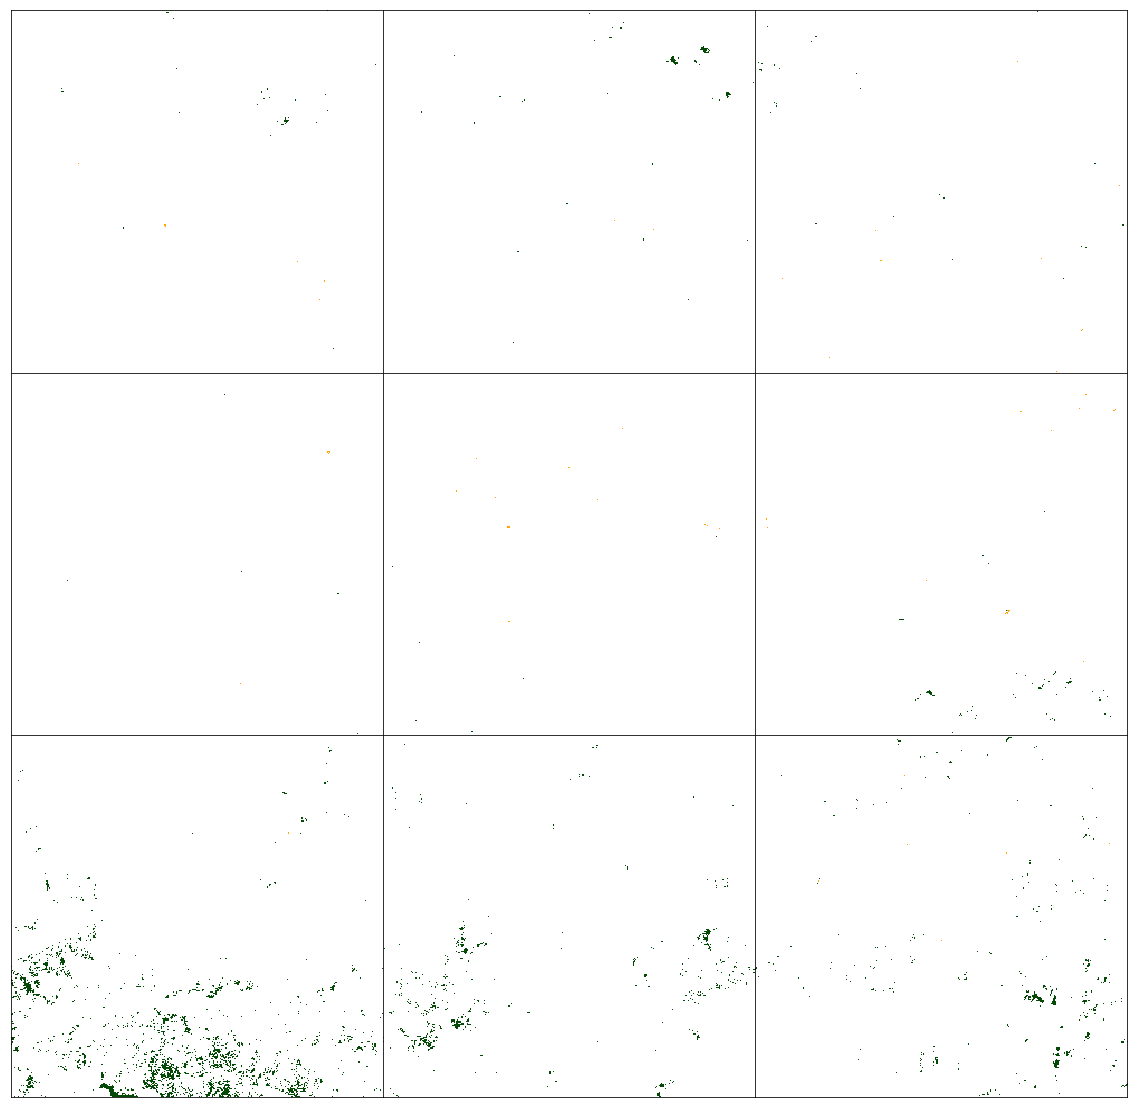

In [117]:

fig, axes = plt.subplots(figsize=(20, 20 * 1), nrows=3, ncols=3)
for i, ax in enumerate(axes.flat):
    eopatch = predictions[i]
    im = ax.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)
    